In [2]:
import pandas as pd
import os.path
from core.util.math import compute_ft
import matplotlib.pyplot as plt
import datetime
from enum import Enum

from user_scripts.Timo.own.console_toolkit import Tk_file, Tk_string

from logic.pulsed.predefined_generate_methods.multi_nv_methods import DQTAltModes, TomoRotations, TomoInit

import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

0

0

# Library

In [3]:
def setup_clear_plots(n_plots):
    n_cur = qdplotlogic.number_of_plots
    for i in range(n_cur):
        n_cur_i = qdplotlogic.number_of_plots
        if n_cur_i >= 1:
            # removing without arguments seems buggy
            qdplotlogic.remove_plot(n_cur_i-1)
    
    for i in range(n_plots):
        qdplotlogic.add_plot()
def extract_num_from_path(file):
    fname = os.path.basename(file)
    res = Tk_string.find_num_in_str(fname)
    
    return res

"""
# delete if Tk_file import works
def load_pulsed_result(fname):

    data = pd.read_csv(fname, sep="\t", comment='#', names=["tau", "z1", "z2", "std1", "std2"])
    if pd.isnull(data.iloc[0, -1]):
        data = pd.read_csv(fname, sep="\t", comment='#', names=["tau", "z1", "std1"])
    meta = Tk_file.load_pulsed_metadata(fname)

    mes = {'data': data,
           'file': fname}
    mes = {**mes, **meta}

    return mes
"""
def do_fit(p_mes, fit_y='delta', fit_method='sine_exp', edit_params=None):
    fitter = pulsedmeasurementlogic.fc   
    
    if edit_params:
        for ov_param in edit_params:
            
            if ov_param.name in fitter.fit_list[fit_method]['parameters'].keys():
                fitter.fit_list[fit_method]['use_settings'][ov_param.name] = True
                fitter.fit_list[fit_method]['parameters'][ov_param.name] = ov_param
                
                #logger.debug(f"Overwriting fit param {ov_param.name}: {ov_param}")

    fitter.clear_result()
    fitter.set_current_fit(fit_method)
    """
    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    result = result.result_str_dict

    result['Position']['value']
    result['FWHM']['value']
    result['Contrast']['value']
    """

    if fit_y == 'delta':
        data = np.asarray(p_mes['data']['tau']), np.asarray(delta_or_z1(p_mes))
    elif fit_y == 'z1':
        data = np.asarray(p_mes['data']['tau']), np.asarray(p_mes['data']['z1'])
    else:
        raise ValueError
    
 
    
    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    # params [lmfit::Parameters] and derived params [dict]
    # considered in _get_fit()
    
    # get values of fitted model
    model = fitter.fit_list[fit_method]['make_model']()[0]
    x_domain = np.asarray(p_mes['data']['tau'])
    y = model.eval(x=x_domain, params=result.params)
    fit_vals = {'x': x_domain, 
                'y': y}
    
    full_result = {**result.params, **result.result_str_dict}
    p_mes['fit_res'] = full_result
    p_mes['fit_values'] = fit_vals

def get_z(p_mes, mode='z1'):
    # mode: z1, z2, delta, (+_norm)
    try:
        has_z2 = True
        try:
            p_mes['data']['z2']
        except KeyError:
            has_z2 = False
            
        tau = p_mes['data']['tau']
        z1 = p_mes['data']['z1']
        z1_norm = z1/np.average(z1)
        
        if mode == 'z1':
            return z1
        elif mode == 'z1_norm':
            return z1_norm
        elif mode == 'z2' or mode == 'z2_norm' or mode=='delta' or mode=='delta_norm':
            if has_z2:
                z2 = p_mes['data']['z2']
                delta = (z1-z2)
                delta_norm = delta/np.average(z1)
            else:
                raise KeyError
                
            if mode == 'z2':
                return z2
            if mode == 'z2_norm':
                return z2/np.average(z2)
            if mode == 'delta':
                return delta
            if mode == 'delta_norm':
                return delta_norm
        else:
            raise ValueError(f"Unknown mode: {mode}")  

    except:
        logger.exception(f"Loading of {mode} from file {p_mes['file']} failed")
        raise  

def delta_or_z1(p_mes, norm=False):
    try:
        has_z2 = True
        try:
            p_mes['data']['z2']
        except KeyError:
            has_z2 = False

        tau = p_mes['data']['tau']
        z1 = p_mes['data']['z1']
        z1_norm = z1/np.average(z1)

        if has_z2:
            z2 = p_mes['data']['z2']
            delta = (z1-z2)
            delta_norm = delta/np.average(z1)

            if norm:
                return delta_norm
            else:
                return delta

        if norm:
            return z1_norm
        return z1
    except:
        logger.exception(f"Loading of file {p_mes['file']} failed")
        raise
        


def pulsed_series_2_array(pulsed_series, idx_var_y=None, ordered_y=True):
    y2d = []
    z1s, z2s = [], []
    x2d = []

    for p in p_raw:
        try:
            z1 = p['data']['z1']
            try:
                z2 = p['data']['z2']
            except:
                z2 = np.nan
            # set x axis of 2d plot
            tau = p['data']['tau']
            # set y axis of 2d plot
            idx_file = extract_num_from_path(p['file'])[-2]
            if idx_var_y != None:
                var_file = float(extract_num_from_path(p['file'])[idx_var_y])
            # set y axis as time of mes
            if idx_var_y == None:
                var_file = p['date'].timestamp() - p_raw[0]['date'].timestamp()
            #logger.info(f"1st: tau {tau}, x2d {x2d}")
            if len(x2d) > 0:
                err = f"Data in file {p['file']} doesn't share tau axis"
                try:
                    if not np.all(x2d == tau):
                        raise ValueError(err)
                except:
                    logger.exception(err)
                    raise


            x2d = tau
            #logger.info(f"tau {tau}, x2d {x2d}")
            y2d.append(var_file)
            z1s.append(z1)
            z2s.append(z2)

        except:
            logger.exception(f"Loading of file {p['file']} failed")
            raise



    z1s = np.asarray(z1s)
    z2s = np.asarray(z2s)

    x2d = np.asarray(x2d)
    y2d = np.asarray(y2d)
    
    if ordered_y:
        y2d,  z1s, z2s = np.sort(y2d), z1s[y2d.argsort()], z2s[y2d.argsort()]
    
    return x2d, y2d, z1s, z2s


def pulsed_series_2_1d_fit_array(pulsed_series, fit_meth, fit_on, fit_vals,
                                 idx_var_x=None, ordered_x=True):
    
    x,y, y2, y3 = [], [], [], []
    dy = []
    
    for p in pulsed_series:
        try:
            # set x axis of 1d plot
            # idx_file = extract_num_from_path(p['file'])[-2]
            if idx_var_x:
                var_file = float(extract_num_from_path(p['file'])[idx_var_x])
            # set y axis as time of mes
            else:
                var_file = p['date'].timestamp() - pulsed_series[0]['date'].timestamp()
            x.append(var_file)
            
            # looks for fit params to overwirte
            edit_params = None
            if 'fit_edit_params' in p.keys():
                edit_params = p['fit_edit_params']
            
            # fit result on y axis
            do_fit(p, fit_y=fit_on, fit_method=fit_meth, edit_params=edit_params)

            y.append(_get_fit(p, 0, error=False, cust_vals=fit_vals))
            dy.append(_get_fit(p, 0, error=True, cust_vals=fit_vals))
            y2.append(_get_fit(p, 1, error=False, cust_vals=fit_vals))
            y3.append(_get_fit(p, 2, error=False, cust_vals=fit_vals))


        except:
            logger.exception(f"Loading of file {p['file']} failed")
            raise

    x, y, y2, y3, dy = np.asarray(x), np.asarray(y), np.asarray(y2),  np.asarray(y3), np.asarray(dy)
    if ordered_x:
        x, y, y2, y3, dy = np.sort(x), y[x.argsort()], y2[x.argsort()], y3[x.argsort()], dy[x.argsort()]
    
    return x, y, y2, y3, dy

def _get_fit(p, y_idx=0, error=False, cust_vals=None):
    import lmfit
    fit_vals = ['Lifetime', 'Contrast', 'Frequency']
    if cust_vals:
        fit_vals = cust_vals
    try:
        param = p['fit_res'][fit_vals[y_idx]]
        if isinstance(param, lmfit.parameter.Parameter):
            fit_quant = 'stderr' if error else 'value'
            return getattr(param, fit_quant)
        elif isinstance(param, dict):
            fit_quant = 'error' if error else 'value'
            return param[fit_quant]
        else:
            raise ValueError(f"Didn't understand fit param type: {type(params)}")
    except:
        return -1
0

0

In [ ]:
# auto nv char

In [4]:
import pandas as pd
import difflib


def overwrite_poi_from_foldername(p_mes):
    # needed, if "Active POI:" property in .dat file is buggy
    path = os.path.normpath(p_mes['file'])
    poi = path.split(os.sep)[-2][:]
    try:
        poi = 'nv_' + poi.rsplit('nv_',1)[1]
    except IndexError:
        return
    #return poi
    #poi.rsplit(poi, '')
    
    if 'Pulsed' in poi:
        return
    else:
        p_mes['poi'] = poi
        return poi

def find_param_file(p_mes):
    return Tk_file.find_param_file(p_mes)

def extract_params_from_file(header_lines):

    header_flat = ' '.join([line for line in header_lines])
    text = header_flat

    # time of experiment
    m = re.search('on(.+?)\n', text)
    if m:
        found = m.group(1)
    date = pd.to_datetime(found, dayfirst=True)

    # poi
    m = re.search('POI:(.+?)\n', text)
    if m:
        found = m.group(1)
    poi = found.lstrip()

    meta = {'date': date,
            'poi': poi}
    return meta

    
def load_param_file(fname):
        
    return Tk_file.load_param_file(fname)

def load_pulsed_params(p_mes):
    fname = find_param_file(p_mes)
    return load_param_file(fname)
    
def decay_fit(p_in, name_timeconst='T2_he', fit_meth='exp_decay'):
    y_val_idx = None
    fit_on = 'delta'
    fit_vals = ['Lifetime', 'None', 'None']
    
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                idx_var_x=y_val_idx, ordered_x=True)
    for p in p_in:
        p[f"fit_res_{name_timeconst}"] = p['fit_res']

def nv_class_for_exp(p_in, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9]):
    for p in p_in:
        try:
            f_mw = load_pulsed_params(p)['microwave_frequency']
            p['exp_on_fres'] = NVClass(find_closest(f_mw, f_res_classes=f_res_classes))
        except KeyError:
            pass
            

def find_best_lor_fit(p_in, fit_meths=['lor_dip', 'lor_dip_2x']):
    
    for i, fmeth in enumerate(fit_meths):
        y_val_idx = None
        fit_on = 'z1'
        fit_meth = fmeth
        fit_vals = ['Position 0', 'Position 1', 'Position 2']    
        if i == 0:
            fit_vals[0] = 'Position'
        
        x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                        fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                        idx_var_x=y_val_idx, ordered_x=True)
        for p in p_in:
            p[f"fit_res_{fmeth}"] = p['fit_res']

        """
        # fit_res is updated after

        y_val_idx = None
        fit_on = 'z1'
        fit_meth = fit_meths[1]
        fit_vals = ['Position 0', 'Position 1', 'None']    

        x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                    fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                    idx_var_x=y_val_idx, ordered_x=True)
        for p in p_in:
            p[f"fit_res_{fit_meths[1]}"] = p['fit_res']
        """

from enum import IntEnum        
class NVClass(IntEnum):
    NOT_CLASSIFIED = -1
    NO_ODMR = -2
    A = 0
    B = 1
    C = 2
    D = 3

    
def classify_nv_orientation(p_mes, fit_meths=['lor_dip', 'lor_dip_2x'],
                            f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9], snr_thresh=10):
    """
    fit meths should be ordered in the number of nvs they correscpond.
    -> lor_dip, lor_dip_2x => n=[1,2]
    """
    p = p_mes
    nv_class = None
    
    chis = []
    for fit in fit_meths:
        if f"fit_res_{fit}" in p.keys():
            chis.append(p[f"fit_res_{fit}"]['chi_sqr']['value'])
    
    i_chi = np.argmin(np.asarray(chis)) 
    n_nv = i_chi + 1
    nv_classes = []
    
    for i_line in range(0, n_nv):
        if n_nv <= 1:
            f_res_i = p[f"fit_res_{fit_meths[0]}"]['Position']['value']
        else:    
            f_res_i = p[f"fit_res_{fit_meths[i_chi]}"][f'Position {i_line}']['value']

        nv_class_i = find_closest(f_res_i, f_res_classes=f_res_classes)
        nv_classes.append(NVClass(nv_class_i))
    
    for i_line in range(0, n_nv):
        if not classify_has_odmr(p, nv_classes, fit_meths=fit_meths, snr_thresh=snr_thresh)[i_line]:
            nv_classes[i_line] = NVClass.NO_ODMR

    """
    # smaller chisqr: better fit
    if chisqr_0 < chisqr_1:
        f_res = p[f"fit_res_{fit_meths[0]}"]['Position']['value']
        nv_class = [NVClass(find_closest(f_res, f_res_classes=f_res_classes))]
        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[0]:
            nv_class = [NVClass.NO_ODMR]

    else:
        f_res_0 = p[f"fit_res_{fit_meths[1]}"]['Position 0']['value']
        f_res_1 = p[f"fit_res_{fit_meths[1]}"]['Position 1']['value']
        nv_class_0 = find_closest(f_res_0, f_res_classes=f_res_classes)
        nv_class_1 = find_closest(f_res_1, f_res_classes=f_res_classes)

        nv_class = [NVClass(nv_class_0), NVClass(nv_class_1)]

        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[0]:
            nv_class[0] = NVClass.NO_ODMR
        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[1]:
            nv_class[1] = NVClass.NO_ODMR
    """
    return nv_classes
        
def classify_nv_orientation_all(p_in, fit_meths=['lor_dip', 'lor_dip_2x'],
                            f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9], snr_thresh=10):  
    for p in p_in:
        try:
            nv_class = classify_nv_orientation(p, fit_meths=fit_meths, f_res_classes=f_res_classes, snr_thresh=snr_thresh)
            p['nv_class'] = nv_class
        except:
            raise ValueError(f"Failed classifiying file: {p_in['fname']}")

def calc_odmr_snr_areal(p_mes, nv_class, fit_meths=['lor_dip', 'lor_dip_2x'], linewidth_expect=[3e6, 50e6]):
    
    def punish_wrong_linewidth(fwhm, linewidth_limit=[0,np.inf]):
        if fwhm < linewidth_limit[0] or fwhm > linewidth_limit[1]:
            return fwhm * 0.05
        
        return fwhm
        
    p = p_mes
    n_fres = len(([int(c) for c in nv_class]))
  
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():
        contr_single = p[f"fit_res_{fit_meths[0]}"]['Contrast']['value']
        contr0 = p[f"fit_res_{fit_meths[1]}"]['Contrast 0']['value']
        contr1 = p[f"fit_res_{fit_meths[1]}"]['Contrast 1']['value']
        fwhm_single = p[f"fit_res_{fit_meths[0]}"]['FWHM']['value']
        fwhm_0 = p[f"fit_res_{fit_meths[1]}"]['FWHM 0']['value']
        fwhm_1 = p[f"fit_res_{fit_meths[1]}"]['FWHM 1']['value']
        y = p['data']['z1']
        
        # todo: ugly hard coded punishment
        fwhm_single = punish_wrong_linewidth(fwhm_single, linewidth_limit=linewidth_expect)
        fwhm_0 = punish_wrong_linewidth(fwhm_0, linewidth_limit=linewidth_expect)
        fwhm_1 = punish_wrong_linewidth(fwhm_1, linewidth_limit=linewidth_expect)
        
        
        signal_single = contr_single * fwhm_single
        signal0 = contr0 * fwhm_0
        signal1 = contr1 * fwhm_1
        
        f_sampling = p['data']['tau'][1] - p['data']['tau'][0]
        # noise in units of contrast
        
        noise_c = 1*np.std(y)/np.mean(y)*100
        noise_area = noise_c * f_sampling
        
        #logger.debug(f"noise: {noise_c}/{noise_area}, signal area: {signal_single}/ {signal0} / {signal1}")
        #logger.debug(f"noise: {noise_c}/{noise_area/1e6}, fwhm: {fwhm_single/1e6}/ {fwhm_0/1e6} / {fwhm_1/1e6}, \
        #             contr {contr_single}, {contr0}, {contr1}")
        
        
        if n_fres <= 1:
            return [signal_single/noise_area] 
        elif n_fres == 2:
            signal = [None, None]
            signal[0] = signal0/noise_area
            signal[1] = signal1/noise_area
            
            return signal
        else:
            raise NotImplemented("Only can handle up to two resonance lines right now")
        
        
def classify_has_odmr(p_mes, nv_class, fit_meths=['lor_dip', 'lor_dip_2x'], snr_thresh=10):
    """
    Compares the fit area against the one from the noise signal
    """
    p = p_mes
    found_odmr = None
 
    n_fres = len(([int(c) for c in nv_class]))
    #logger.debug(f"Got nv class {nv_class} of len {n_fres}")
    
    
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():

        
        if n_fres <= 1:
            signal_single = calc_odmr_snr_areal(p, nv_class, fit_meths)[0]
            found_odmr = [True] if signal_single > snr_thresh else [False]
        elif n_fres == 2:
            signal0, signal1 = calc_odmr_snr_areal(p, nv_class, fit_meths)
            
            found_odmr = [False, False]
            if signal0 > snr_thresh:
                found_odmr[0] = True
            if signal1 > snr_thresh:
                found_odmr[1] = True
        else:
            raise NotImplemented("Only can handle up to two resonance lines right now")
        
        
    return found_odmr  
        

def get_chisqr(p_mes, fit_meths=['lor_dip', 'lor_dip_2x']):
    p = p_mes
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():
        chisqr_0 = p[f"fit_res_{fit_meths[0]}"]['chi_sqr']['value']
        chisqr_1 = p[f"fit_res_{fit_meths[1]}"]['chi_sqr']['value']
            
        idx_best_fit = np.argmin([chisqr_0, chisqr_1])
        return np.min([chisqr_0, chisqr_1]), idx_best_fit
    
def find_closest(f_res, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9]):
    return np.argmin(np.abs(f_res - np.asarray(f_res_classes)))
        
def get_n_odmr_lines(p_mes):   
    
    p = p_mes
    nv_class = p['nv_class']
    nv_class_unique = set(nv_class)
    n_odmr_lines = len([c for c in nv_class_unique if int(c) >= 0])
    
    return n_odmr_lines

def get_mes_for_nv(poi, all_mes, exp_name=None, nv_class=None):
    
    def by_name(p_mes):
        found = False
        
        if exp_name == None and nv_class == None:
            if p_mes['poi'] == poi:
                found = True
        elif exp_name == None and nv_class != None:
            try:
                if p_mes['poi'] == poi and p_mes['exp_on_fres'] == nv_class:
                    found = True
            except KeyError:
                if nv_class == NVClass.NOT_CLASSIFIED:
                    found = True
        elif exp_name != None and nv_class != None:
            try:
                if p_mes['poi'] == poi and p_mes['exp_on_fres'] == nv_class and p_mes['experiment_name'] == exp_name:
                    found = True
            except KeyError:
                if nv_class == NVClass.NOT_CLASSIFIED:
                    found = True
        else:
            found = True if p_mes['poi'] == poi and p_mes['experiment_name'] == exp_name else False
        
        return found
    
    #if nv_class != None:
    #    logger.debug(f"Called exp_name: {exp_name} nv_class {nv_class}")
            
    return list(filter(by_name, all_mes))

def create_table(p_in_odmr, p_in_dd=[], name_tc_dd=['T2_he', 'T2_xy8'], name_exp_dd=['hahn_echo', 'xy8_n']):
    """
    From lists of basis 'measurement per row' compile an output table with 'nv characteristics' per row
    """
    table = []
    
    p_in_dd_flat = []
    [p_in_dd_flat.extend(p_list) for p_list in p_in_dd] 
    p_in_dd = p_in_dd_flat
        
    for i, p in enumerate(p_in_odmr):
        
        # ODMR
        nv_class = p['nv_class']
        nv_class_unique = set(nv_class) 
        
        # for pretty print, don't repeat non-classified results in output string
        nv_class_str = [c.name for c in nv_class_unique]
        if len(nv_class_str) > 1:
            nv_class_str = [c.name for c in nv_class_unique if int(c) >= 0]
        nv_class_str = str(nv_class_str)
        
        n_odmr_lines = get_n_odmr_lines(p)
        
        fit_chisqr, _ = get_chisqr(p)
        fit_snr_list = calc_odmr_snr_areal(p, nv_class)
        fit_snr_0 = None
        fit_snr_1 = None
        if len(fit_snr_list) == 1:
            fit_snr_0 = fit_snr_list[0]
        elif len(fit_snr_list) == 2:
            fit_snr_0 = fit_snr_list[0]
            fit_snr_1 = fit_snr_list[1]
            
        
        row = {'idx': i,
               'poi': p['poi'], 
               'nv_class': nv_class_str, 
               'nv_class_raw': nv_class, 
               'n_odmr': n_odmr_lines,
               'odmr_chi_sqr': fit_chisqr,
               'date_odmr': p['date']}
        #"""
        if fit_snr_0:
            row['snr_0'] = fit_snr_0
        if fit_snr_1:
            row['snr_1'] = fit_snr_1
        #""" 
        
        # HAHN ECHO
        #for i, exp_list in enumerate(p_in_dd):
        for i, exp_name in enumerate(name_exp_dd):
            try:
                classes = [val for val in NVClass]
                for nv_c in classes:
                    p_dd = get_mes_for_nv(p['poi'], p_in_dd, exp_name, nv_c)
                    val_class = nv_c #if (nv_c != NVClass.) else None 
                    if len(p_dd) == 1:
                        nv_class = p_dd[0]['exp_on_fres'].name
                        label = f'{name_tc_dd[i]} (us)'
                        val = [(1e6*p_dd[0][f"fit_res_{name_tc_dd[i]}"]['Lifetime']['value'], val_class)]
                        if label not in row.keys():
                            row[label] = val                                
                        else:
                            row[label] = row[label] + val
                        #row[f'{name_tc_dd[i]}_nv_class'] = nv_class
                    elif len(p_dd) == 0:
                        pass
                    else:
                        logger.warning(f"Found and ignored > 1 he files for poi {p['poi']}. Filter while loading data!")
            except:
                logger.exception(f"Error on poi {p['poi']}, exp: {exp_name}: ")
                
        table.append(row)
    
    df = pd.DataFrame(table)
      
    return df

def handle_duplicate_all_mes(all_p_mes, mode='newer'):
    new_all = copy.deepcopy(all_p_mes)
    for p in all_p_mes:
        len_old = len(new_all)
        new_all = handle_duplicate_mes(p, new_all, mode=mode)
        #logger.debug(f"for {p['poi']}, {p['date']}, {p['experiment_name']}. len: {len_old} => {len(new_all)}")
    return new_all


def handle_duplicate_mes(p_mes, all_p_mes, mode='newer'):
    # delte duplicates and add to 'all mes' list 
    
    pois = [p['poi'] for p in all_p_mes]
    # for performance, skip if no decision can be made
    if p_mes['poi'] not in pois:
        return all_p_mes
    if p_mes['experiment_name'] == None:
        return all_p_mes
    
    def newer(ex_mes):
        """
        Sort out (return False) elements with same poi && experiment name, but older date
        """
        if ex_mes['poi'] == p_mes['poi'] and ex_mes['experiment_name'] == p_mes['experiment_name']:
            # break if on different nv class
            #"""
            if 'exp_on_fres' in ex_mes.keys() and 'exp_on_fres' in p_mes.keys():
                if ex_mes['exp_on_fres'] != p_mes['exp_on_fres']:
                    return True
            #""" 
            if ex_mes['date'] > p_mes['date']:
                return True
            return False
        else:
            return True
    
    def is_dupl(ex_mes):
        if ex_mes['poi'] == p_mes['poi'] and ex_mes['experiment_name'] == p_mes['experiment_name']:
            if 'exp_on_fres' in ex_mes.keys() and 'exp_on_fres' in p_mes.keys():
                if ex_mes['exp_on_fres'] != p_mes['exp_on_fres']:
                    return False
            if ex_mes['date'] > p_mes['date']:
                return False
            return True
            
        return False
        
    
    if mode == 'newer':
        # delete older mes with same poi && name && orientation (if available)
        all_p_mes = list(filter(newer, all_p_mes))
    elif mode == 'all':
        pass
    else:
        raise ValueError(f"Unknown mode: {mode}")
    
    if mode == 'newer' or mode == 'all':
        if not any(map(is_dupl, all_p_mes)):
            all_p_mes.append(p_mes)    
    
    return all_p_mes

def create_header_comment(settings_dict):
    out_str = f""
    date = datetime.datetime.now().strftime("%Y/%m/%d, %H:%M:%S \n")
    out_str = f"# analysis on: {date}"
    for key, val in settings_dict.items():
        out_str += f"# {key}: {val}"
        out_str += "\n"
    
    return out_str

from collections import Iterable
def float2string(input):
    """convert float to string for printing
    """
    if isinstance(input, Iterable):
        return list(map(float2string, input))
    else:
        if input is None:
            return None
        else:
            if isinstance(input, NVClass):
                return f"{input.name}"
            elif float(input).is_integer():
                return "{}".format(input)
            else:
                return "{:.2f}".format(input)

def mean_of_list(cell):
    if isinstance(cell, Iterable):
        #logger.debug(f"Iterable: {cell}")
        return np.nanmean(list(map(mean_of_list, cell)))
    else:
        if cell is None:
            return 0
        else:
            if isinstance(cell, NVClass):
                return np.nan
            else:
                return float(cell)

def flatten_floats_only(cell):
    def _flatten(cell):
        if isinstance(cell, Iterable):
            #logger.debug(f"Iterable: {cell}")
            a = list(map(_flatten, cell))

            #a = [item for sublist in a for item in sublist]
            return a
        else:
            if cell is None:
                return None
            else:
                if isinstance(cell, NVClass):
                    return None
                else:
                    return float(cell)
    
    a = _flatten(cell)
    a = [item for sublist in a for item in sublist]
    a = [item for sublist in a for item in sublist]
    a = [item for item in a if item != None]
    return a
            
def mean_of_list_2(cell):
    # non recursive, slightly less powerfull
    if isinstance(cell, Iterable):
        #logger.debug(f"Iterable: {cell}")
        new_cell = []
        for el in cell:
            if isinstance(el, NVClass):
                el = np.nan
            else:
                el = el
            new_cell.append(el)
                    
        return np.average(np.nanmean(new_cell).flatten())
    else:
        return float(cell)
    
def sort_by_key(df, column, key, ascending=False, drop_nan=False):
    # no idea why not working
    #return df.loc[(df[column].map(key)).argsort()]
    
    df[f'{str(column)}_temp'] = df[column].map(key)
    df = df.sort_values(by=f"{str(column)}_temp")
    if drop_nan:
        df = df.dropna(subset=[column])
    df.drop(f"{str(column)}_temp", axis=1)
    
    if ascending:
        return df[::-1]
    return df


def plot_odmr(p_mes, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9],
              fit_meths=['lor_dip', 'lor_dip_2x'], y_offset=0,
              fig=None, no_nvclass_legend=False, no_poi_legend=False):
    
    if fig == None:
        plt.figure()
    
    poi = p_mes['poi']
    fit_chisqr = p_mes[f"fit_res_{fit_meths[0]}"]['chi_sqr']['value']
    nv_class = p_mes['nv_class']
    odmr_snr = calc_odmr_snr_areal(p_mes, nv_class)

    x = np.asarray(p_mes['data']['tau'])
    y = p_mes['data']['z1'] + y_offset
    #poi_id = mes['file'].split('nv_')[2].split("\\")[0]
        
    label = f"{poi}" if not no_poi_legend else None
    snr_str = f"{odmr_snr[0]:.1f}/ {odmr_snr[1]:.1f}" if len(odmr_snr) == 2 else f"{odmr_snr}"
    title = fr"class= {[c.name for c in nv_class]}, snr= {snr_str}, $\chi^2$= {fit_chisqr:.3f}"
    
    plt.autoscale(True)
    plt.plot(x/1e6,y, label=label, marker="")
    plt.title(title)
    
    # lines for NV orientation classes
    for i, f in enumerate(f_res_classes):
        if not no_nvclass_legend:
            plt.axvline(f/1e6, label=f"{NVClass(i).name}", alpha=0.4+i*0.1, color='grey')
        else:
            plt.axvline(f/1e6, alpha=0.5, color='grey')
    # plot estimated noise level used for "no odmr" classification
    noise = 1*np.std(y)
    mean = np.median(y)
    y0,y1 = mean - noise/2, mean + noise/2
    plt.fill_between(x/1e6, y0, y1, alpha=0.2, color='orange')

    # plot fit
    x = p_mes['fit_values']['x']
    y = p_mes['fit_values']['y']
    plt.autoscale(False)
    plt.plot(x/1e6, y + y_offset, marker="", color='orange', alpha=0.8)    #plt.autoscale(True)
    plt.xlabel(r"f (MHz)")
    
def plot_decay(p_mes, exp_name="T2_he",
              fit_meth='decay_exp', y_offset=0,
              fig=None):
    
    if fig == None:
        plt.figure()
    
    poi = p_mes['poi']

    x = p_mes['data']['tau']
    delta = p_mes['data']['z1'] - p_mes['data']['z2']
    y = delta + y_offset
    #poi_id = mes['file'].split('nv_')[2].split("\\")[0]
    
    t2 = p_mes[f'fit_res_{exp_name}']['Lifetime']['value']
    fit_offset = p_mes[f'fit_res_{exp_name}']['offset'].value
    fit_ampl =  p_mes[f'fit_res_{exp_name}']['amplitude'].value
    label = f"{p_mes['exp_on_fres'].name}: {exp_name}= {1e6*t2:.2f} us, ampl= {fit_ampl:.3f}"
    if fit_offset != 0.:
        label += f"offset= {fit_offset:.3f}"
    
    
    title = f"{poi}"
    plt.plot(1e6*x,y, label=label, marker="")
    plt.title(title)
    plt.xlabel(r"t ($\mu s$)")
    
    # plot fit
    x = p_mes['fit_values']['x']
    y = p_mes['fit_values']['y']
    plt.plot(1e6*x, y + y_offset, marker="", color='orange', alpha=0.8)


0

0

# Load qudi pulsed data

In [ ]:
fname = r"E:\Data\2022\03\20220310\PulsedMeasurement\nv_nv_20220221_80\shaped_exps\CNOT_by_DEER" + "\\" \
        + "20220310-1433-27_deer_dd_tau_pulsed_measurement.dat"

#fname = r"E:\Data\2022\01\20220104\PulsedMeasurement\t2_he_all_roi\roi_south_of_wire\nv_nv_mayd_20211223_47_triple\\20220108-0530-36_podmr_coarse_nv_nv_mayd_20211223_47_pulsed_measurement.dat"

fname = os.path.normpath(fname)
p_data = Tk_file.load_pulsed_result(fname)
fname

In [ ]:
# helps sometimes to get output from print - nevertheless need the cell run 5-10 times!
old_stdout = sys.stdout
old_stdout

# Plot in qudi plot

Need to activate qdplotgui first!

## Only z1

In [ ]:
x = np.asarray(p_data['data']['tau'])
z1 =  np.asarray(p_data['data']['z1'])
z2 = None
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1)

qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(fft_x, fft_delta, plot_index=1)


In [ ]:
p_data['data']

## Alternating: z1,z2; Delta (z1-z2); FFT(Delta) trace

In [ ]:
x = np.asarray(p_data['data']['tau'])
z1 =  np.asarray(p_data['data']['z1'])
z2 = np.asarray(p_data['data']['z2'])
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1-z2)

qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(x, z2, clear_old=False)

qdplotlogic.set_data(x, z1-z2, plot_index=1)

qdplotlogic.set_data(fft_x, fft_delta, plot_index=2)


## Double alternating

Four z per tau [(tau_i, tau_i, tau_i, tau_i), (tau_i+1, tau_i+1, ...), ..]:


    tau_i_1: normal        | -> z1  
    tau_i_2: normal 3pi2   |
    tau_i_3: no DEER pi    | -> z2
    tau_i_4: no DEER 3pi2  |




In [ ]:
x = np.asarray(p_data['tau'])[::2]
z_raw_1 =  np.asarray(p_data['z1'])   # tau_i_1, tau_i_3
z_raw_2 = np.asarray(p_data['z2'])    # tau_i_2, tau_i_4
delta_raw = z_raw_1-z_raw_2
z1 = delta_raw[::2]  # deer
z2 = delta_raw[1::2] # no deer
delta = z1-z2

fft_x, fft_z1 = compute_ft(x_val=x,
                          y_val=z1)
fft_x, fft_z2 = compute_ft(x_val=x,
                          y_val=z2)

setup_clear_plots(3)

#qdplotlogic.set_data(x, z1)
#qdplotlogic.set_data(x, z2, clear_old=False)
#qdplotlogic.set_title("Z1: DEER, Z2: no DEER")

qdplotlogic.set_data(x, z2)
qdplotlogic.set_data(x, z1, clear_old=False)
qdplotlogic.set_title("Z1: no DEER, Z2: DEER")

qdplotlogic.set_data(fft_x, fft_z1, plot_index=1)
qdplotlogic.set_title("FFT(DEER)", plot_index=1)
qdplotlogic.set_data(fft_x, fft_z2, plot_index=2)
qdplotlogic.set_title("FFT(no DEER)", plot_index=2)
0

### Single z1, z2 for deer, no deer

In [ ]:
detail_nodeer_plot = False
detail_deer_plot = not detail_nodeer_plot

# plot pi2, 3pi2: DEER
z_deer = z_raw_1[::2]
z_deer_3pi2 = z_raw_2[::2]

#  plot pi2, 3pi2: no DEER
z_nodeer = z_raw_1[1::2]
z_nodeer_3pi2 = z_raw_2[1::2]

if detail_deer_plot:
    z1 = z_deer
    z2 = z_deer_3pi2
if detail_nodeer_plot:
    z1 = z_nodeer
    z2 = z_nodeer_3pi2

setup_clear_plots(5)
    
qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(x, z2, clear_old=False)
qdplotlogic.set_title("Z1: pi2 read, Z2: 3pi2 read")
qdplotlogic.set_data(x, z1-z2, plot_index=1)
qdplotlogic.set_title("Delta: Z1-Z2", plot_index=1)

fft_x, fft_z1 = compute_ft(x_val=x,
                          y_val=z1)
fft_x, fft_z2 = compute_ft(x_val=x,
                          y_val=z2)
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1-z2)

qdplotlogic.set_data(fft_x, fft_z1, plot_index=2)
qdplotlogic.set_title("FFT(Z1)", plot_index=2)
qdplotlogic.set_data(fft_x, fft_z2, plot_index=3)
qdplotlogic.set_title("FFT(Z2)", plot_index=3)
qdplotlogic.set_data(fft_x, fft_delta, plot_index=4)
qdplotlogic.set_title("FFT(Z1-Z2)", plot_index=4)

# Qudi data series

## Load multiple 1d

In [ ]:
p_raw, x, y, fnames = [], [], [], []

inpath = r"E:\Data\2022\03\20220310\PulsedMeasurement\nv_nv_20220221_80\shaped_exps\CNOT_by_DEER\duplicated_for_plot"
#inpath = r"E:\Data\2021\10\20211026\PulsedMeasurement\rnovel_vs_p_1"

filter_strs = ['pulsed_measurement', '.dat']
#filter_strs += ['podmr_fine']

fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=True)


for f in fnames:
    #p_i = Tk_file.load_pulsed_metadata(f)
    #p_i = {**p_i, **{'file': f, 'data':Tk_file.load_pulsed_result(f)['data']}}
    #p_i = Tk_file.load_pulsed_result(f)
    p_i = Tk_file.load_pulsed_result(f)
    p_raw.append(p_i)

data = load_pulsed_result(p_raw[1]['file'])


In [ ]:
inpath

In [ ]:
p_raw[-1]['date'], len(fnames)

In [ ]:
p_raw[3]['file']

## Load 2d data series

that can be placed in a 2d array, because they share x axis

In [ ]:
p_raw, x, y, fnames = [], [], [], []

inpath = r"E:\Data\2022\03\20220314\PulsedMeasurement\dqt_6x_hfs_alternating_vs_p_2"

fnames = Tk_file.list_mult_pulsed_mes(inpath, incl_subdir=True)

for f in fnames:
    #p_i = Tk_file.load_pulsed_metadata(f)
    #p_i = {**p_i, **{'file': f, 'data':Tk_file.load_pulsed_result(f)['data']}}
    #p_i = Tk_file.load_pulsed_result(f)
    p_i = Tk_file.load_pulsed_result(f)
    p_raw.append(p_i)

data = Tk_file.load_pulsed_result(p_raw[0]['file'])
#Put onto 2d grid: Every row a single pulsed result
x, y, z1s, z2s = pulsed_series_2_array(p_raw, idx_var_y=-1, ordered_y=True)
p_raw[-1]['file']

In [ ]:
p_raw[-1]['date'], p_raw[0]['date'], y

In [ ]:
z2s

## Plot multiple 1d

In [ ]:
#get_z(p_raw[0], mode='delta')

In [ ]:
plot_mode = "z1"
offset = 0
"""
"21_1",  "20_7", "20_2", "20_4"
for i, mes in enumerate(p_raw):
#    if "20_7, 20_11" in mes['file']:
        x_i = mes['data']['tau']
        y_i = offset*i + get_z(mes, mode=plot_mode)
        poi_id = mes['file'].split('nv_')[2].split("\\")[0]
        plt.plot(x_i, y_i, label=f"{poi_id}")
plt.legend()
"""
#"""
plt.figure(figsize=(6,4))
for i, mes in enumerate(p_raw):
    #if "20_4" in mes['file'] or "20_7" in mes['file']  or "20_2" in mes['file']  or "21_1" in mes['file'] :
    x_i = mes['data']['tau']*1e6*15*8 +2
    y_i = offset*i + get_z(mes, mode=plot_mode)
    #poi_id = mes['file'].split('nv_')[2].split("\\")[0]
    poi_id = int(not(i))
    color=None
    if i==0:
        color = '#a51cb3ff'
    elif i==1:
        color = "#b35a1df7"
    
    plt.scatter(x_i, y_i, label=f"control= |{poi_id}>", alpha=0.8, color=color)
    plt.plot(x_i, y_i, label='_nolegend_', color=color, marker="", alpha= 0.4)
#"""

#plt.plot(x_i, np)
plt.xlabel("t_evol (us)")
plt.ylabel("signal")
plt.legend()
plt.show()
0

In [ ]:
plt.scatter(1,1)
plt.show()

## Plot 2d color map

In [ ]:
z2s[0]

In [ ]:
scale_fac = [1e6, 1]
#scale_fac = [1, 1]
#scale_fac = [1e-6, 1]
extent = [x[0]*scale_fac[0], x[-1]*scale_fac[0], y[0]*scale_fac[1], y[-1]*scale_fac[1]]
#plot_labels = ["t (us)", "ise ampl (mV)"]
#plot_labels = ["f (MHz)", "time (s)"]
plot_labels = ["t (us)", "ampl (mV)"]
#plot_labels = ["depol steps ( )", "df (MHz)"]
#plot_labels = ["depol steps ( )", "sweep speed (MHz/us)"]
#plot_labels = ["depol steps ( )", "dd order (mV)"]


idx_cut_y = 12
idx_cut_x = 1
cut_mode = "delta_norm"
cut_mode = "z1"

try:
    try:
        x[idx_cut_x]
    except IndexError:
        idx_cut_x = 0
    try:
        y[idx_cut_y]
    except IndexError:
        idx_cut_y = 0


    if not np.any(np.isnan(z2s[0])):
        delta_norm = (z1s-z2s)/np.average(z1s, axis=1)[:,None]
        z1_norm = (z1s)/np.average(z1s, axis=1)[:,None]
        z2_norm = (z2s)/np.average(z2s, axis=1)[:,None]
        plot_mode = "delta_norm"
    else:
        z1_norm = (z1s)/np.average(z1s, axis=1)[:,None]
        delta_norm = z1_norm
        plot_mode = "z1_norm"

    #plt.figure(figsize=(5,3.5))

    plt.figure(figsize=(9,4))
    plt.subplot(121)
    plt.title(f"{plot_mode}")
    plt.imshow(delta_norm, 
               extent=extent, aspect='auto', origin='lower', cmap="plasma"
              #,vmin=0.14
              #,vmax=0.2
              )

    if cut_mode == "delta_norm":
        plt.axvline(x[idx_cut_x]*scale_fac[0])
        plt.axhline(y[idx_cut_y]*scale_fac[1], color='red')
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.colorbar()


    #plt.ylim(6.6,10)

    plt.subplot(122)
    plt.title("z1")
    plt.imshow(z1s, 
               extent=extent, aspect='auto', origin='lower', cmap="plasma"
              #,vmin=0.85
              )

    if cut_mode == "z1":
        plt.axvline(x[idx_cut_x]*scale_fac[0])
        plt.axhline(y[idx_cut_y]*scale_fac[1], color='red')
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.colorbar()


    plt.tight_layout()
    plt.show()

    # plot cuts
    if cut_mode == "delta_norm":
        zcut = delta_norm
    else:
        zcut = z1s

    plt.figure(figsize=(9,3))
    plt.subplot(121)
    plt.plot(x*scale_fac[0], zcut[idx_cut_y,:], label=f"y={y[idx_cut_y]*scale_fac[1]:.2f}", color='red')
    plt.xlabel(plot_labels[0])
    plt.legend()

    plt.subplot(122)
    plt.plot(y*scale_fac[1], zcut[:,idx_cut_x], label=f"x={x[idx_cut_x]*scale_fac[0]:.2f}")
    plt.xlabel(plot_labels[1])
    plt.legend()



    plt.tight_layout()
    plt.show()
except:
    logger.exception("")

### FFT analysis

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
# 2d fft
ftimage = np.fft.fft2(z1s)
ftimage = np.fft.fftshift(ftimage)
plt.title("2D FFT")
plt.imshow(np.abs(ftimage), vmax=20, aspect='auto')
plt.colorbar()

# fft per line
fft_rows = []
fft_x = None

if cut_mode == "delta_norm":
    zs = delta_norm
elif cut_mode == 'z1':
    zs = z1s
for idx_row, row in enumerate(zs):
    fft_x, fft_delta = compute_ft(x_val=x, y_val=row)
    fft_rows.append(fft_delta)

plt.subplot(122)
plt.title(f"FFT per {cut_mode} row")
extent = [fft_x[0]/scale_fac[0], fft_x[-1]/scale_fac[0], y[0]*scale_fac[1], y[-1]*scale_fac[1]]
plt.imshow(fft_rows, origin='lower', extent=extent, aspect='auto'
          #,vmax=0.05
          #,vmin=0.01
          )
plt.xlim([0,30])
plt.ylabel(plot_labels[1])
plt.xlabel(f"1/({plot_labels[0]})")
plt.colorbar()
plt.show()

In [ ]:
len(row)

## Fit on series

In [ ]:

"""
y_val_idx = -1
x_val = "ampl"
x_unit = "mV"
scale_fac_x = [1]
scale_fac_y = [1e6, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'sine_2x'
fit_vals = ['Lifetime', 'Frequency 1', 'Frequency 2']
fit_units = ['us','MHz', 'MHz']
calc_dxdy_fromto = [(0,-1), (1,-1), False]
"""
"""
y_val_idx = None
x_val = "Time"
x_unit = "h"
scale_fac_x = [1/3600.]
scale_fac_y = [1e-6, 1, 1]
fit_on = 'z1'
fit_meth = 'lor_dip'
fit_vals = ['Position', 'Contrast', 'offset']
fit_units = ['MHz','%', 'a.u.']
calc_dxdy_fromto = [False, (0,30), (0,30)]
"""
"""
y_val_idx = -1
x_val = "ampl"
x_unit = "mV"
scale_fac_x = [1]
scale_fac_y = [1e6, 1e-3, 1e-6]
fit_on = 'delta'
fit_meth = 'sine'
fit_vals = ['Lifetime', 'Frequency', 'Frequency 2']
fit_units = ['us','kHz', 'MHz']
calc_dxdy_fromto = [False, (1,-1), False]
"""
"""
y_val_idx = -1
x_val = "ampl"
x_unit = "mV"
x_val = "sweep speed"
x_unit = "MHz/us"
scale_fac_x = [1]
scale_fac_y = [1, 1, 1e-6]
fit_on = 'delta'
fit_meth = 'decay_exp'
fit_vals = ['Amplitude', 'Lifetime', 'Frequency 2']
fit_units = ['','steps', 'MHz']
calc_dxdy_fromto = [(0,-1), False, False]
"""

#scale_fac_x = [1e-3]
#scale_fac_y = [1e6, 1e-6, 1e-6]
#x_val = "df"
#x_unit = "kHz"
#"""
y_val_idx = None
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e-6, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'lor_dip_2x'
fit_vals = ['Position 0', 'Position 1', 'None']
fit_units = ['MHz','MHz', 'MHz']
calc_dxdy_fromto = [False, False, False]
#"""
"""
y_val_idx = 3
x_val = "idx"
x_unit = ""
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'decay_exp'
fit_vals = ['Lifetime', 'Position 1', 'None']
fit_units = ['ns','MHz', 'MHz']
"""


In [ ]:
fit_vals, scale_fac_y

In [ ]:
p_raw[-1]['date']- p_raw[0]['date'], p_raw[-1]['date'], p_raw[0]['date']

In [ ]:
x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                                fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                idx_var_x=y_val_idx, ordered_x=True)

In [ ]:
x

In [ ]:
plt.figure(figsize=(16,4))


plt.subplot(131)

#plt.scatter(x,1e6*y)
try:
    raise  # don't plot errorbar
    plt.errorbar(scale_fac_x[0]*x,scale_fac_y[0]*y, 
                yerr=scale_fac_y[0]*dy,
                 ecolor='orange', capsize=5, fmt='o', elinewidth=1, capthick=1)
    y_min = np.min(scale_fac_y[0]*y)
    y_max = np.max(scale_fac_y[0]*y)
    #plt.ylim([y_min-abs(0.1*y_min), y_max+abs(0.1*y_max)])
    
except:
    plt.scatter(scale_fac_x[0]*x,scale_fac_y[0]*y)
plt.plot(scale_fac_x[0]*x,scale_fac_y[0]*y)


plt.title(f"Fit {fit_meth} on: {fit_on}")
plt.xlabel(f"{x_val} ({x_unit})")
plt.ylabel(f"{fit_vals[0]} ({fit_units[0]})")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (MHz)")

#plt.xlim(0.5,2)

plt.subplot(132)
plt.scatter(scale_fac_x[0]*x,y2*scale_fac_y[1])
plt.plot(scale_fac_x[0]*x,y2*scale_fac_y[1])
plt.xlabel(f"{x_val} ({x_unit})")
plt.ylabel(f"{fit_vals[1]} ({fit_units[1]})")

if calc_dxdy_fromto[1]:
    idx_slope_from = calc_dxdy_fromto[1][0]
    idx_slope_up_to = calc_dxdy_fromto[1][1]
    dfdx = np.diff(y2)/np.diff(x*scale_fac_x[0])
    avg_dfdx = np.average(dfdx[idx_slope_from:idx_slope_up_to])
    y0 = scale_fac_y[1]* (y2[idx_slope_from]-(x[idx_slope_from]-0)*avg_dfdx)
    
    plt.plot([scale_fac_x[0]*x[idx_slope_from], scale_fac_x[0]*x[idx_slope_up_to]],
             [y2[idx_slope_from]*scale_fac_y[1],
             (scale_fac_y[1]*(y2[idx_slope_from]+((x[idx_slope_up_to]-x[idx_slope_from]))*avg_dfdx*scale_fac_x[0]))],
             label=f"y= {avg_dfdx*scale_fac_y[1]:.4f}x + {y0*scale_fac_y[1]:.4f}", marker="")
    plt.legend()

#plt.ylim(0,10)

plt.subplot(133)
plt.scatter(scale_fac_x[0]*x,y3*scale_fac_y[2])
plt.plot(scale_fac_x[0]*x,y3*scale_fac_y[2])

if calc_dxdy_fromto[2]:
    idx_slope_from = calc_dxdy_fromto[2][0]
    idx_slope_up_to = calc_dxdy_fromto[2][1]

    dfdx = np.diff(y3*scale_fac_y[2])/np.diff(x*scale_fac_x[0])
    avg_dfdx = np.average(dfdx[idx_slope_from:idx_slope_up_to])
    y0 = scale_fac_y[2]* (y3[idx_slope_from]-(x[idx_slope_from]-0)*avg_dfdx)
    
    plt.plot([scale_fac_x[0]*x[idx_slope_from], scale_fac_x[0]*x[idx_slope_up_to]],
             [y3[idx_slope_from]*scale_fac_y[2],
             (y3[idx_slope_from]+((x[idx_slope_up_to]-x[idx_slope_from]))*avg_dfdx*scale_fac_x[0])],
             label=f"y= {avg_dfdx*scale_fac_y[2]/scale_fac_x[0]:.4f}x + {y0*scale_fac_y[2]:.4f}", marker="")
    plt.legend()
    
plt.xlabel(f"{x_val} ({x_unit})")
plt.ylabel(f"{fit_vals[2]} ({fit_units[2]})")
#plt.ylim(0, 1)

plt.tight_layout()
plt.show()
0

In [ ]:
avg_dfdx

### area of exp decay fit

In [ ]:
ampl = scale_fac_y[0]*y
lifetime = scale_fac_y[1]*y2
beta = 1
t_integrate_to = 100

# todo: double check
area = abs(ampl*(lifetime - lifetime/beta*(np.exp(-t_integrate_to/lifetime))**beta))

plt.figure(figsize=(5,3.5))
plt.scatter(x,area)
plt.plot(x,area)
try:
    qdplotlogic.set_data(x, area, clear_old=True)
except: pass
    
plt.ylabel("Area")
plt.xlabel(f"{x_val} ({x_unit})")
plt.show()

In [ ]:
plt.hist(scale_fac_y[0]*y)
plt.show()

## A y cut to qudipolotter

In [ ]:
idx_y_cut = -1

x = np.asarray(p_raw[idx_y_cut]['data']['tau'])
z1 =  np.asarray(p_raw[idx_y_cut]['data']['z1'])
try:
    z2 = np.asarray(p_raw[idx_y_cut]['data']['z2'])
except:
    z2 = np.zeros(p_raw[idx_y_cut]['data']['z1'].shape)
    
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1-z2)

qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(x, z2, clear_old=False)

qdplotlogic.set_data(x, z1-z2, plot_index=1)

qdplotlogic.set_data(fft_x, fft_delta, plot_index=2)


In [ ]:
z1

In [ ]:
fnames[0:4]

# Auto NV characterization

Load data from experimental run with pODMR_coarse, hahn_echo+xy8

In [ ]:

p_raw, x, y, fnames = [], [], [], []

"""
experiments from different folders
inpath = [{'path': r"E:\Data\2022\01\20220104\PulsedMeasurement\t2_he_all_roi",
               'exp': ['all']},
          {'path': r"E:\Data\2022\01\20220109\PulsedMeasurement\t2_xy8_he_all_roi",
               'exp': ["xy8_n","xy8_nsweep", "hahn_echo", "hahnecho"]},
          {'path': r"E:\Data\2022\01\20220127\PulsedMeasurement",
               'exp': ["xy8_n","xy8_nsweep", "hahn_echo", "hahnecho"]}]
"""
inpath = [{'path': r"E:\Data\2022\04\20220425\PulsedMeasurement\nv_nv_20220221_80",
             'exp': ['all']}]

try:
    for in_dict in inpath:
        files = Tk_file.list_mult_pulsed_mes(in_dict['path'], incl_subdir=True)
        for f in files:
            fnames.append({'file': f,
                           'exp': in_dict['exp']})

    for f_dict in fnames:
        
        f = f_dict['file'] 
        exp_name = f_dict['exp']

        p_i = Tk_file.load_pulsed_result(f)
        # extra steps in loading
        try:
            overwrite_poi_from_foldername(p_i)
            p_i['experiment_name'] = load_pulsed_params(p_i)['name']
        except:
            p_i['experiment_name'] = None
            # don't include if experiment_name coulnd't be loaded
            continue
        
        # stream line similar names
        if 'hahn' in p_i['experiment_name']:
            p_i['experiment_name'] = 'hahn_echo'
        if 'xy8_n' in p_i['experiment_name']:
            p_i['experiment_name'] = 'xy8_n'

        if p_i['experiment_name'] in exp_name or 'all' in exp_name:
            p_raw.append(p_i)

except:
    logger.exception("")

len(p_raw)

In [ ]:
p_raw[-3]['date']

DEPRECATED: Add XY8 + HE data from seperate path / measurement

In [ ]:
inpath = [r"E:\Data\2022\01\20220109\PulsedMeasurement\t2_xy8_he_all_roi",
          r"E:\Data\2022\01\20220127\PulsedMeasurement"]
exp_name = [r"xy8_n","xy8_nsweep", "hahn_echo"]

p_in_xy, x, y, fnames = [], [], [], []

try:
    for path in inpath:
        fnames.extend(Tk_file.list_mult_pulsed_mes(path, incl_subdir=True))

    for f in fnames:
        p_i = Tk_file.load_pulsed_result(f)
        # extra steps in loading
        overwrite_poi_from_foldername(p_i)
        try:
            p_i['experiment_name'] = load_pulsed_params(p_i)['name']
        except:
            p_i['experiment_name'] = None
        
        if p_i['experiment_name'] in exp_name:
            p_i['experiment_name'] = exp_name[0]  # make exp names identical
        
        #p_in_xy = handle_duplicate_mes(p_i, p_in_xy, 'newer')
        #p_raw = handle_duplicate_mes(p_i, p_raw, 'all')
        if p_i['experiment_name'] in exp_name:
            p_in_xy.append(p_i)

except:
    logger.exception("")
0

In [ ]:
idx = -1
p_in_xy[idx]['poi'], p_in_xy[idx]['file'], p_in_xy[idx]['experiment_name']

In [ ]:
p_raw[10].keys()


## T2 times

Automatically fit all hahn echo data. ATTENTION: You probably want to un-fix some parameters of the decay_exp fit in qudi afterwards.

In [ ]:
import lmfit

name_t_dd = 'T2_xy8'
f_nv_classes = [2.907e9, 2.963e9, 3.029e9, 3.087e9]
f_nv_classes = [2838.1e6, 2800e6, 2772e6, 2733e6]
f_nv_classes = [2829e6, 2805e6, 2771e6, 2731e6]

p_in_he = [p for p in p_raw if 'hahn'  in p['experiment_name']]
p_in_dd = [p for p in p_raw if 'xy8_n' in p['experiment_name']]

nv_class_for_exp(p_in_he, f_res_classes=f_nv_classes)
nv_class_for_exp(p_in_dd, f_res_classes=f_nv_classes)

p_in_dd = handle_duplicate_all_mes(p_in_dd, 'newer')
p_in_he = handle_duplicate_all_mes(p_in_he, 'newer')

#"""
try:
    # set fit parameters
    for i, p in enumerate(p_in_he):
        # decay_exp fit
         p['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=False),
                                lmfit.Parameter('amplitude', value=0.1, min=0, max=1, vary=True),
                                lmfit.Parameter('beta', value=1, vary=False),
                                lmfit.Parameter('lifetime', value=1e-6, min=10e-9, max=1e-3, vary=True)]
    for i, p in enumerate(p_in_dd):
        # decay_exp fit
         p['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=False),
                                lmfit.Parameter('amplitude', value=-0.1, min=-1, max=0, vary=True),
                                lmfit.Parameter('beta', value=1, vary=False),
                                lmfit.Parameter('lifetime', value=1e-6, min=10e-9, max=1e-3, vary=True)]
        
   
    
    decay_fit(p_in_he, name_timeconst='T2_he', fit_meth='decay_exp')
    decay_fit(p_in_dd, name_timeconst=name_t_dd, fit_meth='decay_exp')
    
except:
    logger.exception("")
    
#handle_duplicate_all_mes"""    

len(p_in_he), len(p_in_dd)

In [ ]:
[(p['experiment_name'] for p in p_raw if 'hahn' in p['experiment_name']]

In [ ]:
idx = 1
p_in_dd[idx]['poi'], p_in_dd[idx]['exp_on_fres'], p_in_dd[idx].keys()

In [ ]:
idx = 0
p_in_he[idx]['poi'], p_in_he[idx]['exp_on_fres'], p_in_he[idx].keys()

In [ ]:
p_in_he[idx]['fit_res']

In [ ]:
pd.DataFrame([(p['poi'], p['date'], p['experiment_name']) for i,p in enumerate(p_raw)]).iloc[0:10]

In [ ]:
pd.DataFrame([(p['poi'], p['date'], p['experiment_name']) for i,p in enumerate(p_in_dd + p_in_he)]).iloc[-5:]
[(p['file']) for i,p in enumerate(p_in_dd + p_in_he)]

## Classify NV orientation

Attention: double check that idx for manual assigment are correct (as in comment)!

In [ ]:
comment = ""
"""
    "manual assignment: \
    double:  \
    20211223: _18, _21, _29, _30, _36, _37, _38, _41, _47  \
    idx: [109,  112, 120, 121, 127, 128, 129, 133, 139] \
    20220103/04: _9, _39, _67, _72, _84, _101, _104 \
    idx: [15, 39, 67, 72, 84, 17, 20] \
    triple: 23_47,  23_40 \
    idx: [139, 132]"
# not implemented yet
# manual_classes = {0: [NVClass.D, NVClass.C]}
"""
p_in = [p for p in p_raw if p['experiment_name'] == 'podmr_coarse']
p_in = handle_duplicate_all_mes(p_in, 'newer')

manual_at_least_double = []#[109,  112, 120, 121, 127, 128, 129, 132, 133, 139] + [15, 39, 67, 72, 84, 17, 20] +  [132, 139]
#manual_at_least_double = [(i, p_in[i]['poi']) for i in manual_at_least_double]

classify_settings = {'snr_thresh': 3,
                     'f_classes': f_nv_classes,
                    # ['lor_dip', 'lor_dip_2x', 'lor_dip_3x'],
                     'fit_meths': ['lor_dip', 'lor_dip_2x'],
                     'comment': comment,
                     'nv_>2x_manual': manual_at_least_double}



In [ ]:
manual_at_least_double

In [ ]:
pd.DataFrame([(p['poi'], p['file']) for i,p in enumerate(p_in)]).iloc[:5]

In [ ]:
try:
    find_best_lor_fit(p_in, fit_meths=classify_settings['fit_meths'])
    classify_nv_orientation_all(p_in, 
                                f_res_classes=classify_settings['f_classes'],
                                fit_meths=classify_settings['fit_meths'],
                                snr_thresh=classify_settings['snr_thresh'])
except:
    logger.exception("")



In [ ]:
idx = 0
classify_has_odmr(p_in[idx], p_in[idx]['nv_class']), \
calc_odmr_snr_areal(p_in[idx], p_in[idx]['nv_class']), \
classify_nv_orientation(p_in[idx], snr_thresh=3)


In [ ]:
p_in[0]['nv_class']

### Result table

Presents the full table of potential double NVs. These can be 1. automatically detected, 2. manually assigned. We keep two different list df_double and df_double_incl_manual.

In [ ]:
df[df['n_odmr'] > 2]

In [ ]:

pd.set_option("display.precision", 2)
list_formatters = {'T2_xy8 (us)':float2string, 'T2_he (us)':float2string}


try:
     
    df = create_table(p_in, p_in_dd=[p_in_he, p_in_dd], 
                                     name_tc_dd=['T2_he', 'T2_xy8'],
                                     name_exp_dd=['hahn_echo', 'xy8_n'])
    df_double = df[df['n_odmr'] > 1]
    manual_not_found = set([tup[1] for tup in manual_at_least_double]) - set(df_double['poi'].tolist()) 
    df_double_incl_manual = df[df['poi'].isin(manual_not_found)].append(df_double) 
except:
    logger.exception("")
    #
    # df[df['poi'].isin(manual_not_found)][['nv_class','poi', 'T2_he (us)', 'T2_xy8 (us)']]

  

# need to execute a few times for print to show up
try:
    print(sort_by_key(df_double_incl_manual, 'T2_xy8 (us)', mean_of_list).to_string(
        columns=['nv_class','poi', 'T2_he (us)', 'T2_xy8 (us)'],
        formatters=list_formatters,
        float_format=float2string))
except:
    logger.exception("")

In [ ]:
poi = "nv_20220221_80"
get_mes_for_nv(poi, p_in_dd, exp_name='xy8_n')[0].keys()#[0]['fit_res']

In [ ]:
poi = 'nv_mayd_20220104_68'
pd.DataFrame([(p['experiment_name'], p['exp_on_fres'], p['date']) for p in get_mes_for_nv(poi, p_in_dd + p_in_he)])

Pretty print via matplotlib

In [ ]:
df_pretty = copy.deepcopy(df).sort_values(by=['poi'])
# filter out columns
df_pretty = df_pretty.loc[:, df_pretty.columns!='nv_class_raw']
#df.reindex(columns=['poi', 'date', 'n_odmr', 'nv_class', 'snr_0', 'snr_1'])
#df_pretty.update(df_pretty[['snr_0', 'snr_1', 'odmr_chi_sqr', 'T2_he (us)',  'T2_xy8 (us)']].applymap('{:,.2f}'.format))

plt.figure(figsize=(23,5))
table = plt.table(cellText=df_pretty.values, colLabels=df_pretty.columns, loc="center")
table.auto_set_column_width(col=list(range(len(df_pretty)))) # Provide integer list of columns to adjust

plt.axis('off')
plt.show()


In [ ]:
len(df[df['T2_he (us)'] > 5])

#### Export to common base dir

In [ ]:
path_list = [p['file'] for p in p_in]
fname_export = os.path.commonpath(path_list) + "\\" + "auto_char.csv"

with open(fname_export, 'w') as f:
    f.write(f"{create_header_comment(classify_settings)} \n")
    df.to_csv(f, sep=";", decimal=",")
fname_export

#create_header_comment(classify_settings)

### T2 histogram

In [ ]:
t2_names = ['T2_he (us)', 'T2_xy8 (us)']
x_in_log = False
t2_clip_us = [-np.inf, 900]

try:
    for t2 in t2_names:
        all_poi_he = (df[['poi']].stack().values) # stack to remove nan
        single_t2_he = np.asarray(flatten_floats_only(df[df['n_odmr'] == 1][[t2]].stack().values))
        single_a_t2_he = flatten_floats_only(df[df['n_odmr'] == 1 &(NVClass.A in df['nv_class_raw'])][[t2]].stack().values)
        single_b_t2_he = flatten_floats_only(df[df['n_odmr'] == 1 & (NVClass.B in df['nv_class_raw'])][[t2]].stack().values)
        single_c_t2_he = flatten_floats_only(df[df['n_odmr'] == 1 & (NVClass.C in df['nv_class_raw'])][[t2]].stack().values)
        single_d_t2_he = flatten_floats_only(df[df['n_odmr'] == 1 & (NVClass.D in df['nv_class_raw'])][[t2]].stack().values)
        double_t2_he = np.asarray(flatten_floats_only(df[df['n_odmr'] > 1][[t2]].stack().values))
        double_poi_he = df[df['n_odmr'] > 1][['poi']].stack().values
        
        t2_classes = [single_a_t2_he, single_b_t2_he, single_c_t2_he, single_d_t2_he, double_t2_he]
        
        # for mean calculation, clip away outliers manually
        double_t2_he_clip = double_t2_he[double_t2_he > t2_clip_us[0]]
        double_t2_he_clip = double_t2_he[double_t2_he < t2_clip_us[1]]
        single_t2_he_clip = single_t2_he[single_t2_he > t2_clip_us[0]]
        single_t2_he_clip = single_t2_he[single_t2_he < t2_clip_us[1]]
        
        label = ['A', 'B', 'C', 'D', 'double']
        title = f"double fraction= {len(double_poi_he)/len(all_poi_he)*100:.1f} % (from {len(all_poi_he)})"
        color = ['skyblue', 'dodgerblue', 'navy', 'blue', 'orange']

        #plt.figure(figsize=(6,4.5))
        if x_in_log:
            bins=np.logspace(np.log10(1),np.log10(1000), 70)
        else:
            bins = 70
        plt.hist(t2_classes, bins=bins, label=label, stacked=True, color=color)
        if x_in_log:
            plt.xscale('log')
        #plt.xlim(bins[0]/2, bins[1])
        
        plt.axvline(np.mean(double_t2_he_clip), label=f"mean double= {np.mean(double_t2_he_clip):.1f} us", color='orange')
        plt.axvline(np.mean(single_t2_he_clip), label=f"mean single= {np.mean(single_t2_he_clip):.1f} us", color='navy')
        plt.axvline(t2_clip_us[0], label=f"clip mean= {t2_clip_us[0]} us", color='red', alpha=0.5,
                    linestyle='dashed')
        plt.axvline(t2_clip_us[1], label=f"clip mean= {t2_clip_us[1]} us", color='red', alpha=0.5,
                    linestyle='dashed')
        
        
        plt.title(title)
        plt.xlabel(rf"{t2} ($\mu s$)")
        plt.legend()
        plt.show()
except:
    logger.exception("")

In [ ]:
len(df[t2])

In [ ]:


for t2 in t2_names:
    double_t2 = df[df['n_odmr'] > 1][[t2]].stack().values
    double_t2
    double_t2_with_val = []
    for t2_l in double_t2:
        if len(t2_l) == 2:
            double_t2_with_val.append(t2_l)
    t2_nv_a = pd.DataFrame(double_t2_with_val)[[0]]
    t2_nv_b = pd.DataFrame(double_t2_with_val)[[1]]

    t2_nv_a = flatten_floats_only(t2_nv_a.values)
    t2_nv_b = flatten_floats_only(t2_nv_b.values)
    
    t2_max = np.max(np.concatenate([t2_nv_a, t2_nv_b]))
    
    plt.figure(figsize=(4,3))
    plt.scatter(t2_nv_a, t2_nv_b)
    plt.xlabel(rf"{t2}_A ($\mu s$)")
    plt.ylabel(rf"{t2}_B ($\mu s$)")
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlim([0,1.1*t2_max])
    plt.ylim([0,1.1*t2_max])
    plt.show()
    

### Plot potential doubles

In [ ]:
# double ('all'): 35, 43, 51, 52, 53

offset = 0.15
idx_plotted = 0
fig = plt.figure()

try:
    nv_doubles = df_double_incl_manual['poi'].tolist()
    for i, p in enumerate(p_in):
        if p['poi'] in nv_doubles \
            and get_n_odmr_lines(p) > 1:

            plot_odmr(p, fig=fig, y_offset = offset*idx_plotted, no_nvclass_legend=True)
            idx_plotted += 1

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
except:
    logger.exception("")

### Plot odmr and T2 fits

In [ ]:


# INTERESTING NV ON BUGGY 20211224 DATA
# 'all'
# orientations: 6, 55, 10, 16
# noise: 18, 19
# double: 35, 43, 51, 52, 53

# handle duplicate 'newer'
# orientations: 4, 42, 7, 8
# doubles: 31, 39, 40, 43, 49

# ON 20220104 DATA
# doubles: 15, 26
try:
    idx_list = [109]
    nv_doubles = sort_by_key(df_double_incl_manual, 'T2_xy8 (us)', mean_of_list, 
                         ascending=True, drop_nan=True)
    idx_list = nv_doubles['idx'].tolist()
    for idx in idx_list[:]:
        #idx = 109# 128
        f_res_classes=f_nv_classes

        fig = plt.figure(figsize=(16,4))
        fig.suptitle(f"idx= {idx}, {p_in[idx]['poi']}", fontsize=16, y=1.02)

        plt.subplot(131)
        plot_odmr(p_in[idx], f_res_classes=f_res_classes, fig=fig, no_poi_legend=True)
        plt.legend()
        #plt.show()
        
        plt.subplot(132)
        for p_he in get_mes_for_nv(p_in[idx]['poi'], p_in_he, 'hahn_echo'):
            plot_decay(p_he, exp_name='T2_he', fig=fig)
        plt.legend()
        #plt.show()
        
        p_dds = get_mes_for_nv(p_in[idx]['poi'], p_in_dd, 'xy8_n')
        if p_dds:
            plt.subplot(133) 
        for p_dd in p_dds:
            plot_decay(p_dd, exp_name='T2_xy8', fig=fig)
        if p_dds:
            plt.legend()

        #plt.tight_layout()
        plt.show()
except:
    logger.exception("")
0

In [ ]:
idx= 109
p1 = get_mes_for_nv(p_in[idx]['poi'], p_in_he, 'hahn_echo')[0]
p2 = get_mes_for_nv(p_in[idx]['poi'], p_in_he, 'hahn_echo')[1]

In [ ]:
pd.DataFrame([(p['poi'], p['nv_class']) for i,p in enumerate(p_in)]).iloc[:-20]

In [ ]:
plot_decay(p_dd)

In [ ]:
len(idx_list)

# Tomography

In [5]:
import lmfit

def tomography_1q_from_2rabi(fit_dict, pmes_rabi_ref):
    if len(fit_dict) != 2:
        raise ValueError
    
  
    fit_x = [val['fit_res'] for (key, val) in fit_dict.items() if val['exp_params']['rabi_phase_deg'] == 0][0]
    fit_y = [val['fit_res'] for (key, val) in fit_dict.items() if val['exp_params']['rabi_phase_deg'] == 90][0]
    ampl0, ampl1, y0s =  fits_2_tomo_params(fit_x, fit_y, pmes_rabi_ref)
    #return (ampl0, ampl1, y0s)
    return _tomo_1q_rabi(ampl0, ampl1, y0s)

    
    
def tomography_2q_from_2rabi(fit_dict, pmes_rabi_ref_0, pmes_rabi_ref_1):
    pass


def _tomo_1q_rabi(ampls_0=[0, 0], ampls_1=[0, 0], y0=[0,0]):
    # input the fit results to Rabi oscillations driven around the X and Y axis
    # result is a density matrix reconstructed from a linear square solution to
    # the overdetermined system given by Neumann PhD (3.24)
    # a*x=b where x=[a,b,c,d] with variable names like in (3.21)
    
    y0x = y0[0]
    y0y = y0[1]
    A0x = ampls_0[0]
    A0y = ampls_0[1]
    A1x = ampls_1[0]
    A1y = ampls_1[1]
    
    a = np.zeros((6, 4))
    a[0,0] = 1/2
    a[0,3] = 1/2
    a[1,0] = 1/2
    a[1,3] = 1/2
    a[2,0] = -1/2
    a[2,3] = 1/2
    a[3,0] = -1/2
    a[3,3] = 1/2
    a[4,2] = -1
    a[5,1] = 1
    
    b = [y0x, y0y, A0x, A0y, A1x, A1y]
    
    x, _, _, _= np.linalg.lstsq(a, b)
    
    rho = np.zeros((2,2), dtype=complex)
    a,b,c,d = x[0], x[1], x[2], x[3]
    rho[0,0] = a
    rho[0,1] = complex(b, c)
    rho[1,0] = complex(b, -c)
    rho[1,1] = d
    
    return rho
   

def norm_cts_2_pop(i_cts, cts_max=1, cts_min=0.7, is_ampl=False):
    from scipy.interpolate import interp1d
    
    if is_ampl:
        mapper = interp1d([cts_max-cts_min,0],[1,0], fill_value='extrapolate')
    else:
        mapper = interp1d([cts_max,cts_min],[1,0], fill_value='extrapolate')
    return mapper(i_cts)

def fits_2_tomo_params(fit_rabi_x, fit_rabi_y, pmes_rabi_ref):
    
    f_x = fit_rabi_x
    f_y = fit_rabi_y
    
    cts_max = np.max(pmes_rabi_ref['fit_values']['y'])
    cts_min = np.min(pmes_rabi_ref['fit_values']['y'])

    ampls_0 = norm_cts_2_pop([f_x[0], f_y[0]], cts_min=cts_min, cts_max=cts_max, is_ampl=True)
    ampls_1 = norm_cts_2_pop([f_x[1], f_y[1]], cts_min=cts_min, cts_max=cts_max, is_ampl=True)
    y0s = norm_cts_2_pop([f_x[2], f_y[2]], cts_min=cts_min, cts_max=cts_max)
    
    #if ampls_0 < 0 or ampls_1 > 1 or ampls_1 < 0 or ampls_1 > 1:
    #    logger.warning("Found unreasonable Rabi amplitudes. Norm error?")
    
    return ampls_0, ampls_1, y0s


def fit_rabis(pmes_list, zdata='delta'):
    
    p_raw = pmes_list
    
    """
    Using a fit 'expression' to fix the frequencies of the two sines seem broken.
    So instead: 1. find the frequency in a 'sine' fit and 2. fix this in a 'sine_2x' fit
    """

    y_val_idx = None
    fit_on = zdata #'delta'
    fit_meth = 'sine'
    fit_vals = ['frequency', 'None', 'None']

    for i, p in enumerate(p_raw):
        z_i = get_z(p, mode=zdata)
        ampl_guess = (np.max(z_i) - np.min(z_i))/2
        offset_guess = np.mean(z_i)
        p_raw[i]['fit_edit_params'] = [#lmfit.Parameter('frequency', value=10e6, vary=True, min=0),
                                    #lmfit.Parameter('phase', value=0, vary=True, min=-np.pi, max=np.pi),
                                    lmfit.Parameter('beta', value=1, vary=False),
                                    #lmfit.Parameter('lifetime', value=np.inf, vary=False)
                                    #lmfit.Parameter('lifetime', value=10e-6, vary=True, min=10e-9),
                                    #lmfit.Parameter('amplitude', value=ampl_guess, vary=True, min=0),
                                    #lmfit.Parameter('offset', value=offset_guess, vary=True)
                                   ]

    _, f, _, _, _ = pulsed_series_2_1d_fit_array(p_raw, fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                    idx_var_x=y_val_idx, ordered_x=False)
   
    for i, fres in enumerate(f):
        # Debug
        #x = np.asarray(p_raw[i]['data']['tau'])
        #y = np.asarray(get_z(p_raw[i], mode=zdata))
        #logger.debug(f"X: {x}, Y: {y}")
        
        #qdplotlogic.set_data(x, y, plot_index=i%3)
        #logger.debug(f"[{i}]: Fitted f= {fres}, sine_1x init: {p_raw[i]['fit_edit_params']}, full: {p_raw[i]['fit_res']}")
        
        #"""
        p_raw[i]['fit_edit_params'] = [lmfit.Parameter('s1_frequency', value=fres, vary=False),
                                       lmfit.Parameter('s2_frequency', value=fres, vary=False),
                                       lmfit.Parameter('s1_phase', value=-np.pi/2, vary=False),
                                       lmfit.Parameter('s2_phase', value=0, vary=False),
                                       lmfit.Parameter('lifetime', value=np.inf, vary=False)]

    
    y_val_idx = None

    fit_on = zdata #'delta'
    fit_meth = 'sine_2x'
    fit_vals = ['Amplitude 1', 'Amplitude 2', 'Offset']
    #"""

    _, a1s, a2s, y0s, _ = pulsed_series_2_1d_fit_array(p_raw, fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                    idx_var_x=y_val_idx, ordered_x=False)
    

    fit_rabi = {}
    rabi_ref = {}

    logger.debug(f"Fit rabi on {len(a1s)} loaded tomographic rabis.")
    
    # find whether all mes are a tomography of |00>
    is_tomo_00 = False
    inits = []
    for idx, a1 in enumerate(a1s):
        try:
            params = p_raw[idx]['exp_params']
            inits.append(params['init_state'])
        except:
            logger.exception(f"Error while loading mes params from file: {p_raw[idx]['file']}")
    is_tomo_00 =  all([i==TomoInit.none for i in inits])
    
    # sort reference (init=0, rot=0) and tomographic measurements
    for idx, a1 in enumerate(a1s):
        try:
            params = p_raw[idx]['exp_params']
        
            on_nv = params['rabi_on_nv']
            init = params['init_state']
            rotation = params['rotation']
            phase = params['rabi_phase_deg']
        
        except:
            logger.exception(f"Error while loading mes params from file: {p_raw[idx]['file']}")
        fit_res = [a1, a2s[idx], y0s[idx]]
        
        mes_key = '/fail'
        
        if not isinstance(rotation, Enum) or not isinstance(init, Enum):
            logger.warning(f"Found non enum type init_state/rotation in file, did parsing fail? {p_raw[idx]['file']}")
        
        if is_tomo_00:
            is_tomo_mes = True
        else:
            is_tomo_mes = (init != TomoInit.none)
        
        if is_tomo_mes:
            if  params['rabi_phase_deg'] == 0:
                mes_key = f'rabi{on_nv}_{init.name}_{rotation.name}_x'
                fit_rabi[mes_key] = {'fit_res': fit_res, 'exp_params': params}
            elif params['rabi_phase_deg'] == 90:
                mes_key = f'rabi{on_nv}_{init.name}_{rotation.name}_y'
                fit_rabi[mes_key] = {'fit_res': fit_res, 'exp_params': params}
        
        if init == TomoInit.none and rotation == TomoRotations.none and phase == 0:
            mes_key = f"rabi_ref_on_{on_nv}"
            rabi_ref[mes_key] = p_raw[idx]

        
        logger.debug(f"Sorted= {mes_key!='/fail'} for params init={init}, rot={rotation}, on_nv={on_nv} => {mes_key} on file: {p_raw[idx]['file']}")
            
    return fit_rabi, rabi_ref


def plot_rabis_for_tomo(pmes_list, ref_rabis, idx_plot=0, zdata='delta'):
    
    
    pmes = pmes_list[idx_plot]
    try:
        on_nv = pmes['exp_params']['rabi_on_nv']
        for pmes_rabi_ref in ref_rabis:
            if pmes_rabi_ref['exp_params']['rabi_on_nv'] == on_nv:
                break
        logger.debug(f"For mes from {pmes['file']} on nv {on_nv} take ref rabi: {pmes_rabi_ref['file']}")
    except Exception as e:
        logger.warning(f"Couldn't auto find ref rabi: {str(e)}")
        pmes_rabi_ref = ref_rabis[0]
        on_nv = '/na'
    
    p_tau = pmes['data']['tau']
    p_y = get_z(pmes, mode=zdata)
    p_y_fit = pmes['fit_values']['y']
    p_tau_full_osci =  pmes_rabi_ref['data']['tau']
    p_y_full_osci = get_z(pmes_rabi_ref, mode=zdata)

    # for a perfect pi2 init, (cts_max-cts_min)/2 = ampls_1[0 or 1] and ampls_0(0 and 1) == 0
    cts_max = np.max(pmes_rabi_ref['fit_values']['y'])
    cts_min = np.min(pmes_rabi_ref['fit_values']['y'])
    
    logger.debug(f"Fit on ref rabi, min/max= {cts_min}/{cts_max}. Data min/max= {np.min(p_y_full_osci)}/{np.max(p_y_full_osci)}")
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    
    plt.title("Normed")
    plt.plot(p_tau, norm_cts_2_pop(pmes['fit_values']['y'], cts_min=cts_min, cts_max=cts_max),
             color='blue', marker='', label=f"fit idx={idx_plot} Rabi")
    plt.plot(p_tau_full_osci, norm_cts_2_pop(pmes_rabi_ref['fit_values']['y'], cts_min=cts_min, cts_max=cts_max),
             color='orange', marker='', label=f"fit ref Rabi {on_nv}")
    plt.plot(p_tau, norm_cts_2_pop(p_y, cts_min=cts_min, cts_max=cts_max),
             color='blue', marker='o', linestyle='None', label=f"data idx={idx_plot}")
    plt.plot(p_tau_full_osci, norm_cts_2_pop(p_y_full_osci, cts_min=cts_min, cts_max=cts_max),
             color='orange', marker='o', linestyle='None', label="data ref Rabi")

    plt.legend()
    plt.subplot(122)
    plt.title("Raw data")
    plt.plot(p_tau, p_y,  color='blue',label=f"idx={idx_plot} Rabi, raw")
    plt.plot(p_tau,  p_y_fit, color='blue', label=f"fit idx={idx_plot} Rabi, raw", marker='')
    plt.plot(p_tau_full_osci, p_y_full_osci, color='orange', label="ref Rabi, raw", alpha=0.5)
    plt.legend()

    plt.show()

0

0

## Load Rabi data with different rotations

We need data that contains a Rabi rotation around X and Y after the initialized state plus a tomographic rotation gate.
As contrast reference, there should also be a data file without rotation and Rabi along X.

In [40]:
"""
#fname = r"E:\Data\2022\02\20220222\PulsedMeasurement\char_roi_north\nv_nv_20220221_80" + "\\" \
      #  + "20220224-0638-04_rabi_fine_nv_nv_20220221_80_pulsed_measurement.dat"
"""
p_raw, x, y, fnames = [], [], [], []

#inpath = r"E:\Data\2022\02\20220224\PulsedMeasurement\nv_20220221_2_1q_tomography_test"
#inpath = r"E:\Data\2021\10\20211026\PulsedMeasurement\rnovel_vs_p_1"
#inpath = r"E:\Data\2022\04\20220414\PulsedMeasurement\dummy_tomography_tests\single_qubit"
inpath = r"D:\Data\2022\04\20220429\PulsedMeasurement\init_0+1,0+1"

filter_strs = ['pulsed_measurement', '.dat']
#filter_strs += ['rabi']

try:
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)


    for f in fnames:
        #p_i = Tk_file.load_pulsed_metadata(f)
        #p_i = {**p_i, **{'file': f, 'data':Tk_file.load_pulsed_result(f)['data']}}
        #p_i = Tk_file.load_pulsed_result(f)
        p_i = Tk_file.load_pulsed_result(f)
        p_raw.append(p_i)
except:
    logger.exception("")
        
len(p_raw)

18

In [ ]:
type(p_raw)

In [ ]:
Tk_file.load_pulsed_result(f)

In [ ]:
y_val_idx = None
fit_on = 'z1' #'delta'
fit_meth = 'sine'
fit_vals = ['frequency', 'None', 'None']

_, f, _, _, _ = pulsed_series_2_1d_fit_array(p_raw, fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                idx_var_x=y_val_idx, ordered_x=True)

f

### Fake data

In [ ]:
# FAKE params for 1 qubit tomo 
import copy as cp
p_raw.append(cp.deepcopy(p_raw[1]))

# reference rabi: phase doesn't matter, but init=0
p_raw[1]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.none, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}

p_raw[0]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}
p_raw[2]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 90, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}

len(p_raw)

In [ ]:
# FAKE params for 2 qubit tomo
p_raw.append(cp.deepcopy(p_raw[1]))
p_raw.append(cp.deepcopy(p_raw[1]))
p_raw.append(cp.deepcopy(p_raw[1]))
p_raw.append(cp.deepcopy(p_raw[1]))


# reference rabis: phase doesn't matter, but init=0
p_raw[1]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.none, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}
p_raw[5]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 2, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.none, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}


p_raw[0]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}
p_raw[2]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 90, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}
p_raw[3]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 2, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}
p_raw[4]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 2, 'rabi_phase_deg': 90, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}

len(p_raw)

In [ ]:
p_raw[0]['exp_params']['rotation'] == TomoRotations.none, p_raw[0]['exp_params']['init_state'] == TomoInit.none 

In [ ]:
isinstance(p_raw[0]['exp_params']['rotation'], Enum)

## 1 qubit tomography

For an arbitrary init state, record a Rabi driven around X, Y there after. Fit those measurements and reconstruct density matrix.
ATTENTION: Erases all 'edits' from pulsed fit settings for 'sine' and 'sine_2x'

In [ ]:


try:
    tomo_rabis, ref_rabis = fit_rabis(p_raw, zdata='z1')
    rho = tomography_1q_from_2rabi(tomo_rabis, list(ref_rabis.values())[0])
except:
    logger.exception("")

len(tomo_rabis)
#tomo_rabis
#list(ref_rabis.values())[0]
#rho
#fits_2_tomo_params
#tomography_1d_from_rabi(ampls_0, ampls_1, y0s)

## 2 qubit tomography

In [41]:

def _get_fit_rabi_pairs(rabi_entry, fit_dict):
    search_params = rabi_entry['exp_params']
    
    found = {}
    for (key, val) in fit_dict.items():
        i_params = val['exp_params']
        if i_params['rotation'] == search_params['rotation'] \
            and i_params['init_state'] == search_params['init_state'] \
            and i_params['rabi_on_nv'] == search_params['rabi_on_nv']:
            found[key] = val
    
    if len(found) != 2:
        raise ValueError(f"Couldn't find x,y rabi. So far: {found.keys()}")
    
    return found
0
#len(_get_fit_rabi_pairs(tomo_rabis['rabi1_none_ux180_on_1_x'], tomo_rabis).keys())

0

ATTENTION: Need to unfix all params in pulsed gui fit settings before running!

In [45]:
import copy as cp
def tomography_2q_from_2rabi(fit_dict, pmes_rabi_ref_1, pmes_rabi_ref_2):
    
    def multiply(new_val, rho_el):
        ret_val = None
        flag_done = False   # for every rho element, need (rabi_x, rabi_y) mes on nv_1 and nv_2!
                
        if np.isnan(rho_el):
            ret_val = new_val
        else:
            ret_val = rho_el*new_val
            flag_done = True 
        
        logger.debug(f"Got new_val {new_val} for rho {rho_el} => {ret_val}")
        
        return ret_val, flag_done
    
    rho = np.ones((4,4), dtype=complex) * np.nan
    done = np.ones((4,4), dtype=bool) * False
    done_rots = []
    
    for  (key, val) in fit_dict.items():
        rabi_pair = _get_fit_rabi_pairs(val, fit_dict)
        
        on_nv = val['exp_params']['rabi_on_nv']
        rotation = val['exp_params']['rotation']
        #logger.info(f"At item {key} with rot {rotation} and on {on_nv}")
        if on_nv == 1:
            tomo_1q = tomography_1q_from_2rabi(rabi_pair, pmes_rabi_ref_1)
        elif on_nv == 2:
            tomo_1q = tomography_1q_from_2rabi(rabi_pair, pmes_rabi_ref_2)
    
        if (rotation, on_nv) in done_rots:
            # rabi_pair already handled, note that 2 (_x, _y) elements in fit_dict will lead to same pair
            continue
        
        rho_saved = cp.copy(rho)
        
        # target matrix rho_arb = [(a, e, f, g), (b, h, i), ...]
        # from source sub matrices of single systems [(a1, c1),(conj(c1), b1)], [(a2, c2), (...)] 
        # for summed readout, every entry of target rho_arbi is a multiplication of sub matrix elements
        # different to the original Neumann method -> see lab notes
        
        if rotation == TomoRotations.none:
            if on_nv == 1:
                
                # population
                # a, b, c, d
                rho[0,0], done[0,0] = multiply(tomo_1q[0,0], rho[0,0])   # a1*a2
                rho[1,1], done[1,1] = multiply(tomo_1q[0,0], rho[1,1])   # a1*b2
                rho[2,2], done[2,2] = multiply(tomo_1q[1,1], rho[2,2])   # b1*a2
                rho[3,3], done[3,3] = multiply(tomo_1q[1,1], rho[3,3])   # b1*b2

                # coherences
                # f
                rho[0,2], done[0,2] = multiply(tomo_1q[0,1], rho[0,2])   # c1*a2
                # e
                rho[0,1], done[0,1] = multiply(tomo_1q[0,0], rho[0,1])   # a1*c2
                rho[2,0], done[2,0] = np.conj(rho[0,2]), done[0,2]    # c1*a2
                rho[1,0], done[1,0] = np.conj(rho[0,1]), done[0,1]   # a1*c2
                
                # OLD Neumann: get a, c, f 
                #rho[1,1] = tomo_1q[0,0]
                #rho[0,2] = tomo_1q[0,1]   # REALL
                #rho[2,0] = tomo_1q[1,0]   # REALLY
                #rho[2,2] = tomo_1q[1,1]
            elif on_nv == 2:
                
                # population
                # a, b, c, d
                rho[0,0], done[0,0] = multiply(tomo_1q[0,0], rho[0,0])   # a1*a2
                rho[1,1], done[1,1] = multiply(tomo_1q[1,1], rho[1,1])   # a1*b2
                rho[2,2], done[2,2] = multiply(tomo_1q[0,0], rho[2,2])   # b1*a2
                rho[3,3], done[3,3] = multiply(tomo_1q[1,1], rho[3,3])   # b1*b2  
                
                # coherences
                # f
                rho[0,2], done[0,2] = multiply(tomo_1q[0,0], rho[0,2])   # c1*a2
                # e 
                rho[0,1], done[0,1] = multiply(tomo_1q[0,1], rho[0,1])   # a1*c2
                rho[2,0], done[2,0] = np.conj(rho[0,2]), done[0,2]   # c1*a2
                rho[1,0], done[1,0] = np.conj(rho[0,1]), done[0,1]   # a1*c2
                
                
                # OLD Neumann: get (a), b, e
                #rho[0,0] = tomo_1q[0,0] # value doubled
                #rho[0,1] = tomo_1q[0,1]  # REALLY?
                #rho[1,0] = tomo_1q[1,0] # REALLY?
                #rho[1,1] = tomo_1q[1,1]
                
            logger.info(f"At item {key} with rot {rotation} and on {on_nv} re(rho)= {np.real(tomo_1q)}")
            
        elif rotation == TomoRotations.c1not2:
            if on_nv == 1:
                rho[0,3], done[0,3] = multiply(tomo_1q[0,1], 1) #c1*c2 Roberto
                rho[3,0], done[3,0] = np.conj(rho[0,3]),done[0,3]
                #continue
            else:
                continue
                # OLD Neumann: get (a), (d), g
                #rho[0,3] = tomo_1q[0,1] # REALLY?
                #rho[3,0] = tomo_1q[1,0] # REALLY?
                #rho[3,3] = tomo_1q[1,1]
        
        elif rotation == TomoRotations.ux180_on_2:
            #todo: still not correct
            #"""
            if on_nv == 1:
                # coherences
                # i
                rho[1,3], done[1,3] = multiply(tomo_1q[0,1], rho[1,3])   # c1*a2
                rho[3,1], done[3,1] = np.conj(rho[1,3]), done[1,3]       # c1*a2
                
            elif on_nv == 2:
                rho[1,3], done[1,3] = multiply(tomo_1q[0,0], rho[1,3])   # c1*a2
                rho[3,1], done[3,1] = np.conj(rho[1,3]), done[1,3]       # c1*a2
                # OLD Neumann: get (b), d, i
                #rho[1,3] = tomo_1q[0,1] # REALLY?
                #rho[3,1] = tomo_1q[1,0] # REALLY?
                #rho[3,3] = tomo_1q[1,1]
            #"""
        elif rotation == TomoRotations.ux180_on_1:
            # todo: still not correct
            #"""
            if on_nv == 1:
                # coherences
                # i
                rho[2,3], done[2,3] = multiply(tomo_1q[0,0], rho[2,3])   # a1*c2
                rho[3,2], done[3,2] = np.conj(rho[2,3]), done[2,3]       # 
                
            elif on_nv == 2:
                rho[2,3], done[2,3] = multiply(tomo_1q[0,1], rho[2,3])   # 
                rho[3,2], done[3,2] = np.conj(rho[2,3]), done[2,3]       # 
                
                # OLD Neumann: get (c), (d), j
                #rho[2,3] = tomo_1q[0,1] # REALLY?
                #rho[3,2] = tomo_1q[1,0] # REALLY?
            #"""
        elif rotation == TomoRotations.c2not1_ux180_on_1:
            if on_nv == 2:
                #continue
                 rho[1,2], done[1,2] = multiply(tomo_1q[0,1],1) # c1*c2 Roberto
                 rho[2,1], done[2,1] =  np.conj(rho[1,2]), done[1,2] 
            else:
                continue
                # OLD Neumann: get (b),(c), conj(h)
                #rho[2,3] = np.conj(tomo_1q[0,1]) # REALLY?
                #rho[3,2] = np.cong(tomo_1q[1,0]) # REALLY? 
        else:
            continue
        
        done_rots.append((rotation, on_nv)) 
        logger.debug(f"Sorting rho_{on_nv}=\n{tomo_1q} into rho: rot= {rotation},\
                     re(rho)=\n{np.real(rho)}, re(rho_before)=\n{np.real(rho_saved)} key= {key}")
    
    success = done[~np.isnan(rho)].all()
    logger.debug(f"done: {done}")
    if not success:
        raise ValueError(f"Not enough data to reconstruct. done array: {done}")
    
    return rho

rho = -1
try:
    tomo_rabis, ref_rabis = fit_rabis(p_raw, zdata='delta')  # 'z1'

    #if len(list(ref_rabis.values())) != 2:
     #   raise ValueError("Expected 2 rabi reference measurements, 1 on each NV")
        
    rho = tomography_2q_from_2rabi(tomo_rabis, list(ref_rabis.values())[0], list(ref_rabis.values())[1])
except:
    logger.exception("")

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


rhoReal = np.real(rho)
rhoImag = np.imag(rho)

#rhoReal
rhoImag
#np.savetxt(inpath + "\TestMatrixRealPart.txt",rhoReal)
#np.savetxt(inpath + "\TestMatrixImagPart.txt",rhoImag)

array([[ 0.    ,  0.2032,  0.2308, -0.7822],
       [-0.2032,  0.    , -0.368 ,  0.1199],
       [-0.2308,  0.368 ,  0.    ,  0.0781],
       [ 0.7822, -0.1199, -0.0781,  0.    ]])

In [34]:
print(fit_dict.items())

Traceback (most recent call last):
  File "C:\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-1db82aa7b1d2>", line 1, in <module>
    print(fit_dict.items())
NameError: name 'fit_dict' is not defined


In [ ]:
ref_rabis.keys(), tomo_rabis.keys()

## Plot Rabis

Attention: an offset between the reference Rabi and a certain measurement is relevant, even for correct amplitudes! 
    Both are used for the tomography, so we can't just omit any offset.

'D:\\Data\\2022\\04\\20220429\\PulsedMeasurement\\init_0+1,0+1/20220429-1724-51_tomography_on1_rot=none_phi=0_init_ux90_on_both_pulsed_measurement.dat'

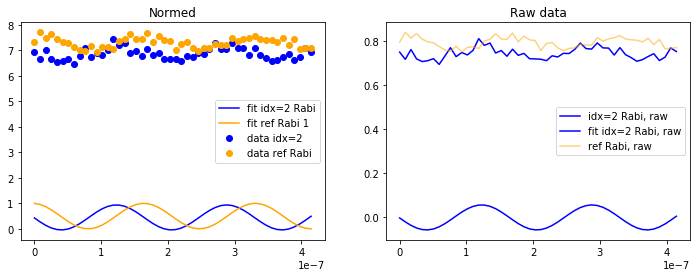

In [43]:
idx = 2
try:
    plot_rabis_for_tomo(p_raw, list(ref_rabis.values()), idx, zdata='z1')
except:
    logger.exception("")

p_raw[idx]['file']

In [ ]:
p_raw[1]['fit_res']

In [ ]:
fitter = pulsedmeasurementlogic.fc
fitter.set_current_fit(fit_meth)

fitter.fit_list[fit_meth]['parameters']['s2_amplitude']

In [20]:
print(rho[0,3])

Traceback (most recent call last):
  File "C:\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-cdd5555ffee3>", line 1, in <module>
    print(rho[0,3])
TypeError: 'int' object is not subscriptable
